In [1]:
import numpy as np
import torch
import os
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd

import matplotlib.pyplot as plt

import NW_LSTM
import NN_DataLoader

# Global

In [2]:
data_dir=r'C:\Users\ossia\Documents\GitHub\MagLearn-Bristol-2\Single Pipeline\preprocessed_training_dataset_4'
max_samples = 2000 # Max number of timeseries-temperature-frequency-loss samples per material, increase if validating larger datasets and compute time is not limited

In [3]:
weights_dir = os.path.join(data_dir, 'Trained Weights') # Directory containing weighted material models
training_data_dir = os.path.join(data_dir, 'Processed Training Data') # Directory of pre-processed training data
validation_dir = os.path.join(data_dir, 'Validation') # Directory where plots and files for model validation will be stored
os.makedirs(validation_dir, exist_ok=True) # Creates folder if it does not already exist

# Check if 'Trained Weights' folder exists and contains material models
if os.path.isdir(weights_dir):
    # Get the list of models from the weights_dir folder, extracting the name of each .ckpt model which conventionally corresponds to the material name
    weights = [os.path.splitext(item)[0] for item in os.listdir(weights_dir)
                if item.endswith('.ckpt') and os.path.isfile(os.path.join(weights_dir, item))]
    if weights == []:
        raise RuntimeError(f'No .ckpt models found in "{weights_dir}", ensure "Trained Weights" subfolder in data_dir contains individual .ckpt files corresponding to each trained material.')
else:
    print(f'No subfolder labeled "Trained Weights" found at "{data_dir}", please ensure this exists and contains individual .ckpt files corresponding to each trained material.')

# Print the list of trained models found
print("Identified weightings for the following materials:", weights)

Identified weightings for the following materials: ['3C90', '3C94', '3E6', '3F4', '77', '78', 'N27', 'N30', 'N49', 'N87']


## processing...

In [4]:
# Check if CUDA is available and if so, set the device to GPU
device = torch.device("cpu")
print("Device using ", device)

class MyDataset(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

Device using  cpu


Data size  4071
model parameters:  90653
3C90 error distribution histogram saved to C:\Users\ossia\Documents\GitHub\MagLearn-Bristol-2\Single Pipeline\preprocessed_training_dataset_4\Validation\3C90.pdf
Data size  4006
model parameters:  90653
3C94 error distribution histogram saved to C:\Users\ossia\Documents\GitHub\MagLearn-Bristol-2\Single Pipeline\preprocessed_training_dataset_4\Validation\3C94.pdf
Data size  699
model parameters:  90653
3E6 error distribution histogram saved to C:\Users\ossia\Documents\GitHub\MagLearn-Bristol-2\Single Pipeline\preprocessed_training_dataset_4\Validation\3E6.pdf
Data size  656
model parameters:  90653
3F4 error distribution histogram saved to C:\Users\ossia\Documents\GitHub\MagLearn-Bristol-2\Single Pipeline\preprocessed_training_dataset_4\Validation\3F4.pdf
Data size  1144
model parameters:  90653
77 error distribution histogram saved to C:\Users\ossia\Documents\GitHub\MagLearn-Bristol-2\Single Pipeline\preprocessed_training_dataset_4\Validation\77

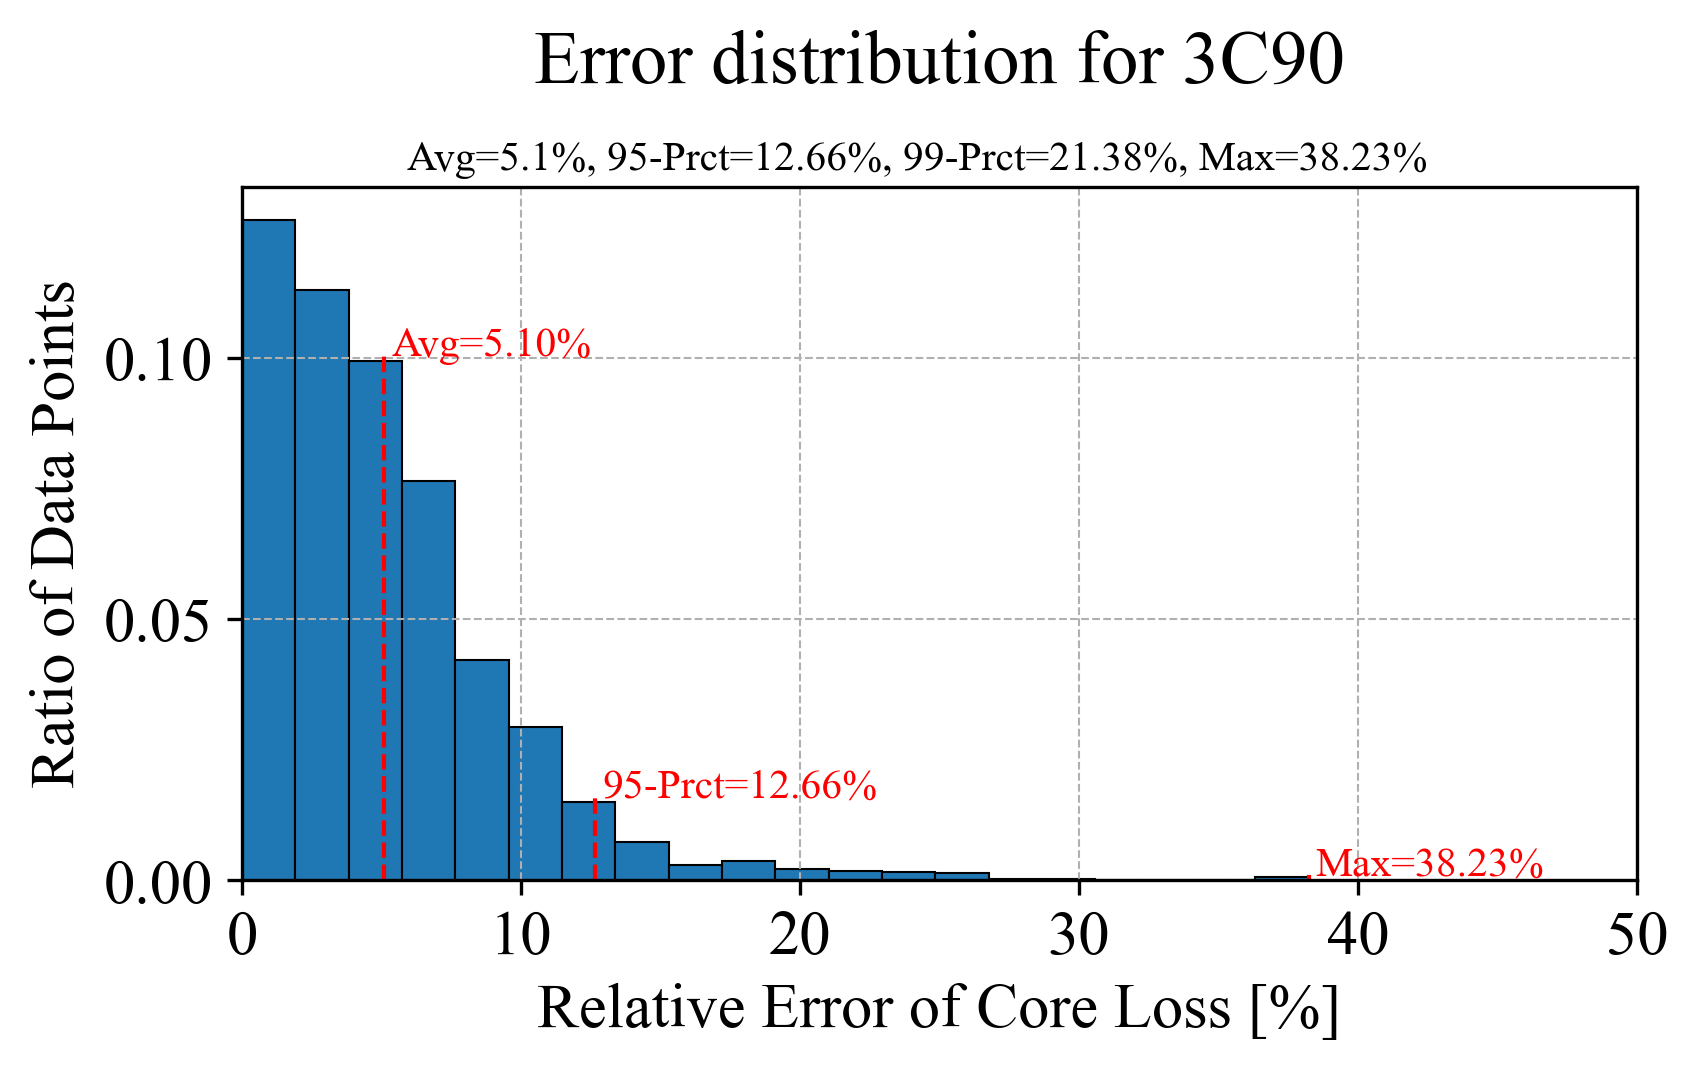

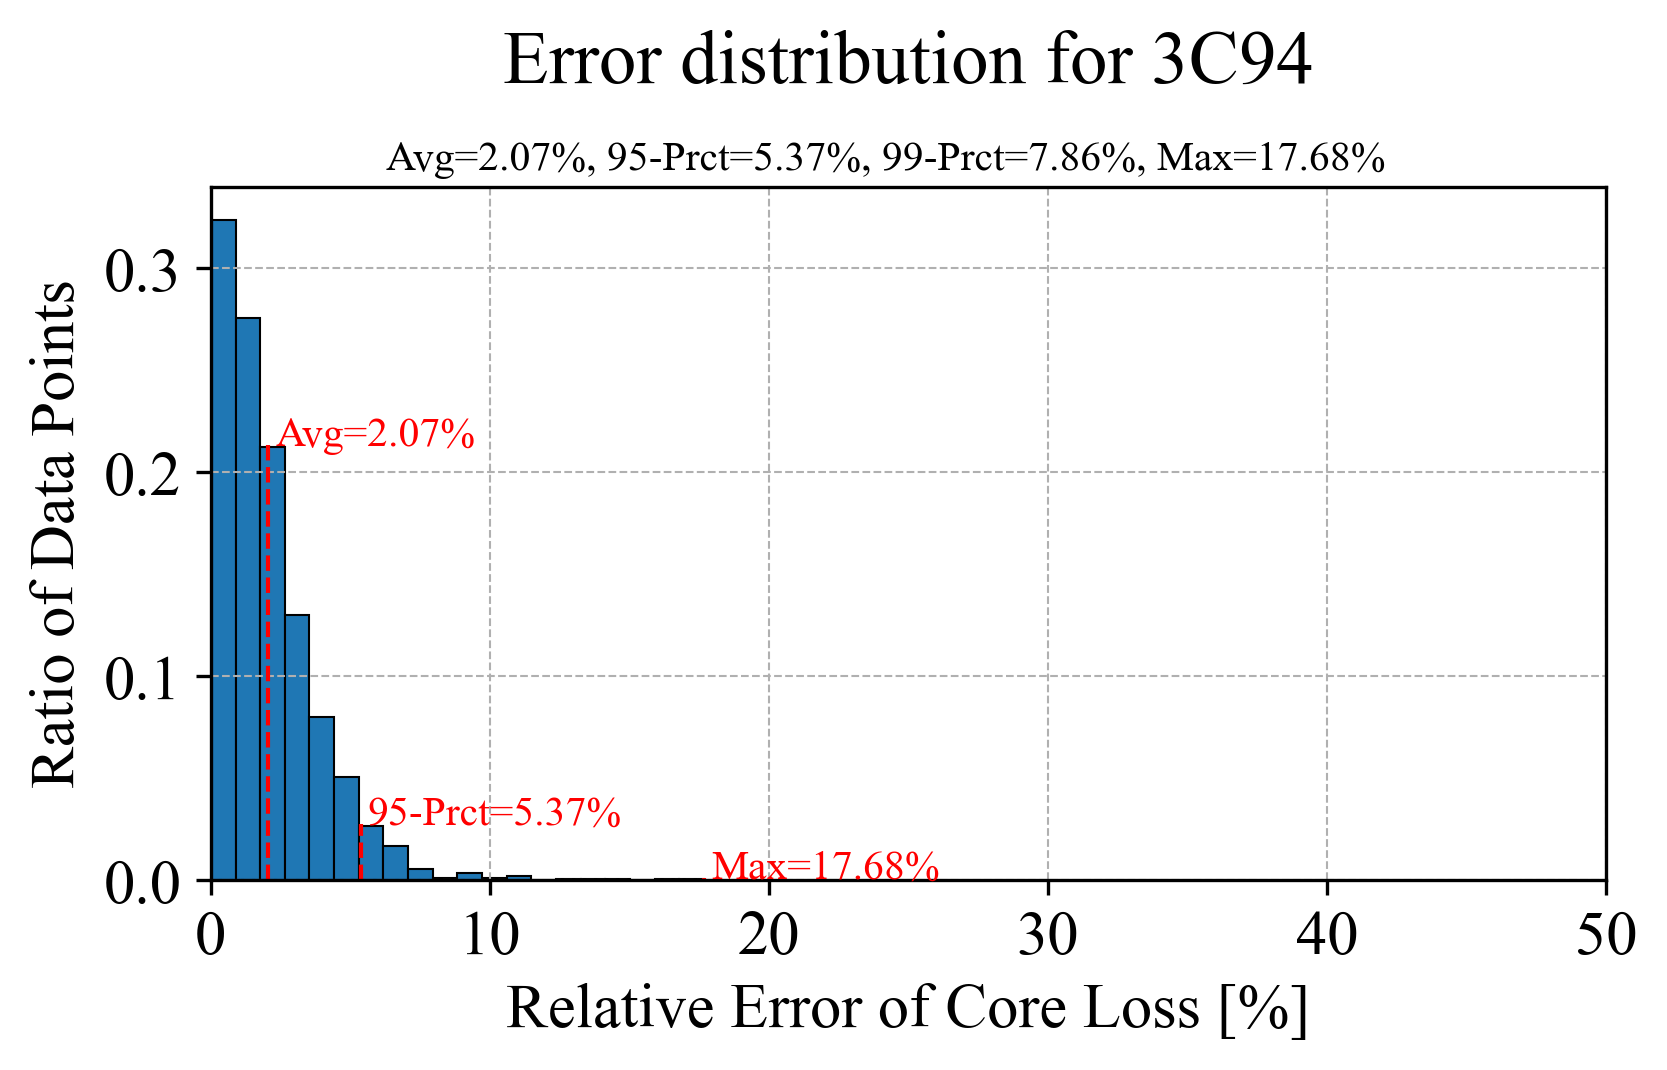

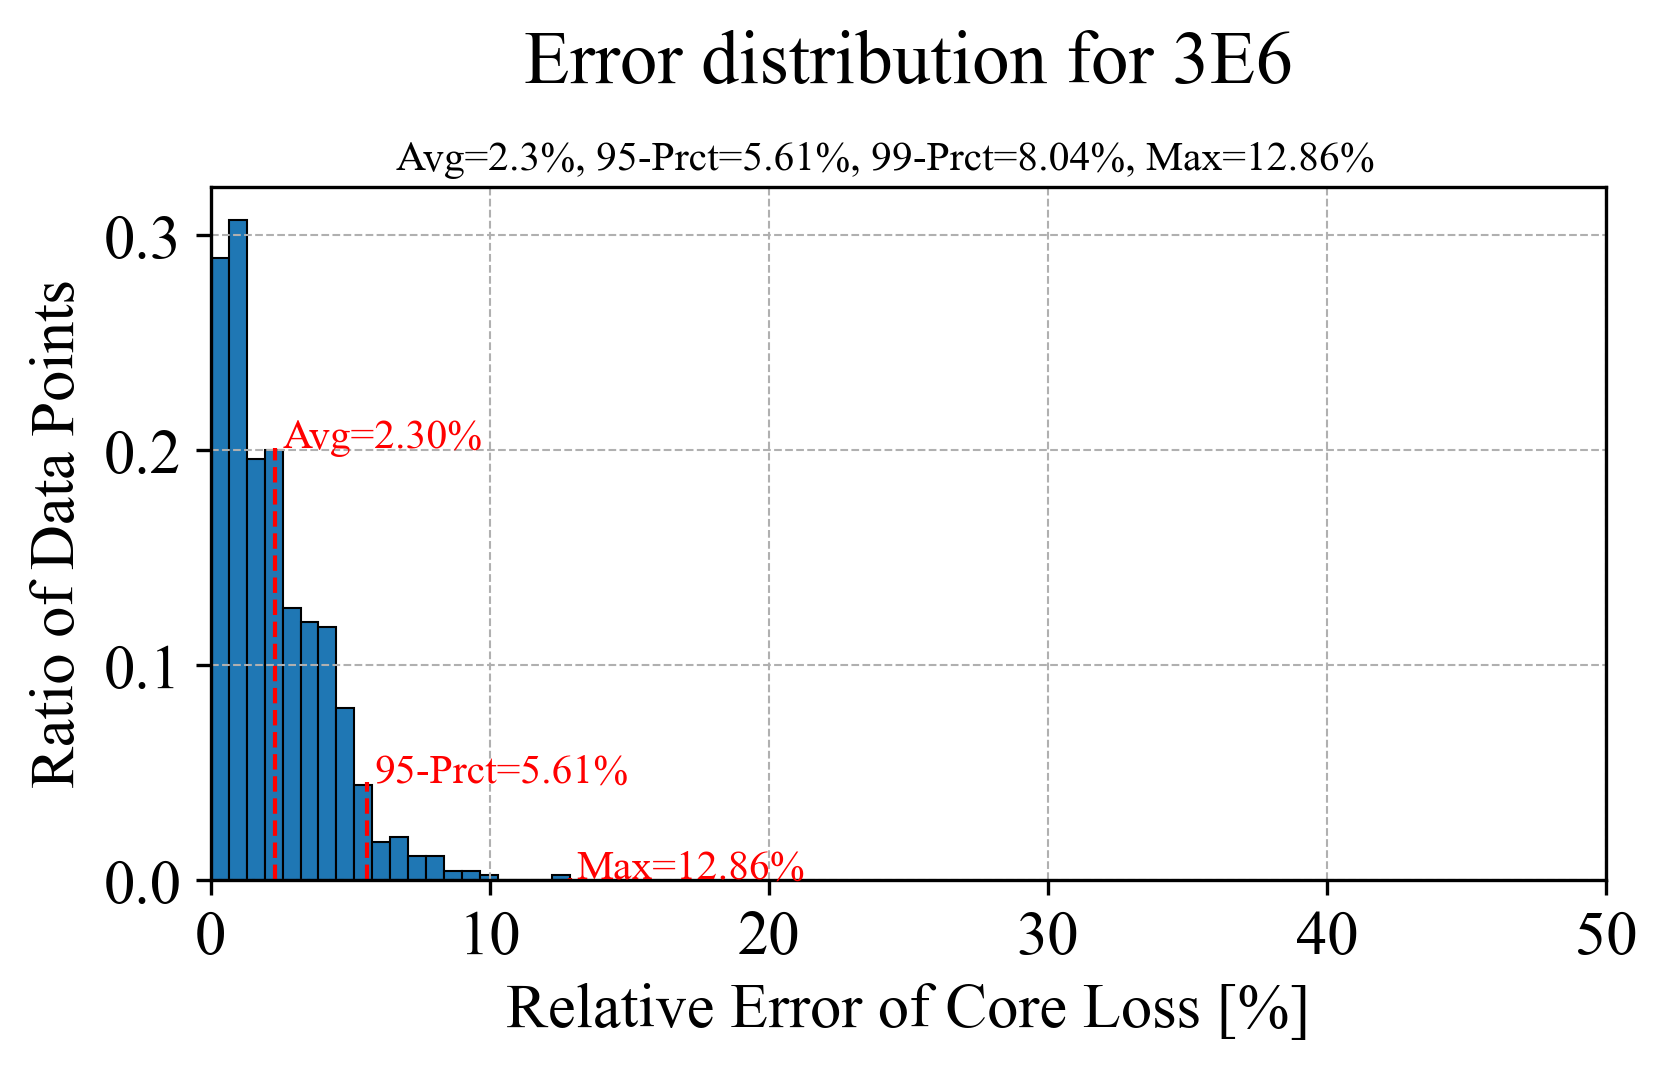

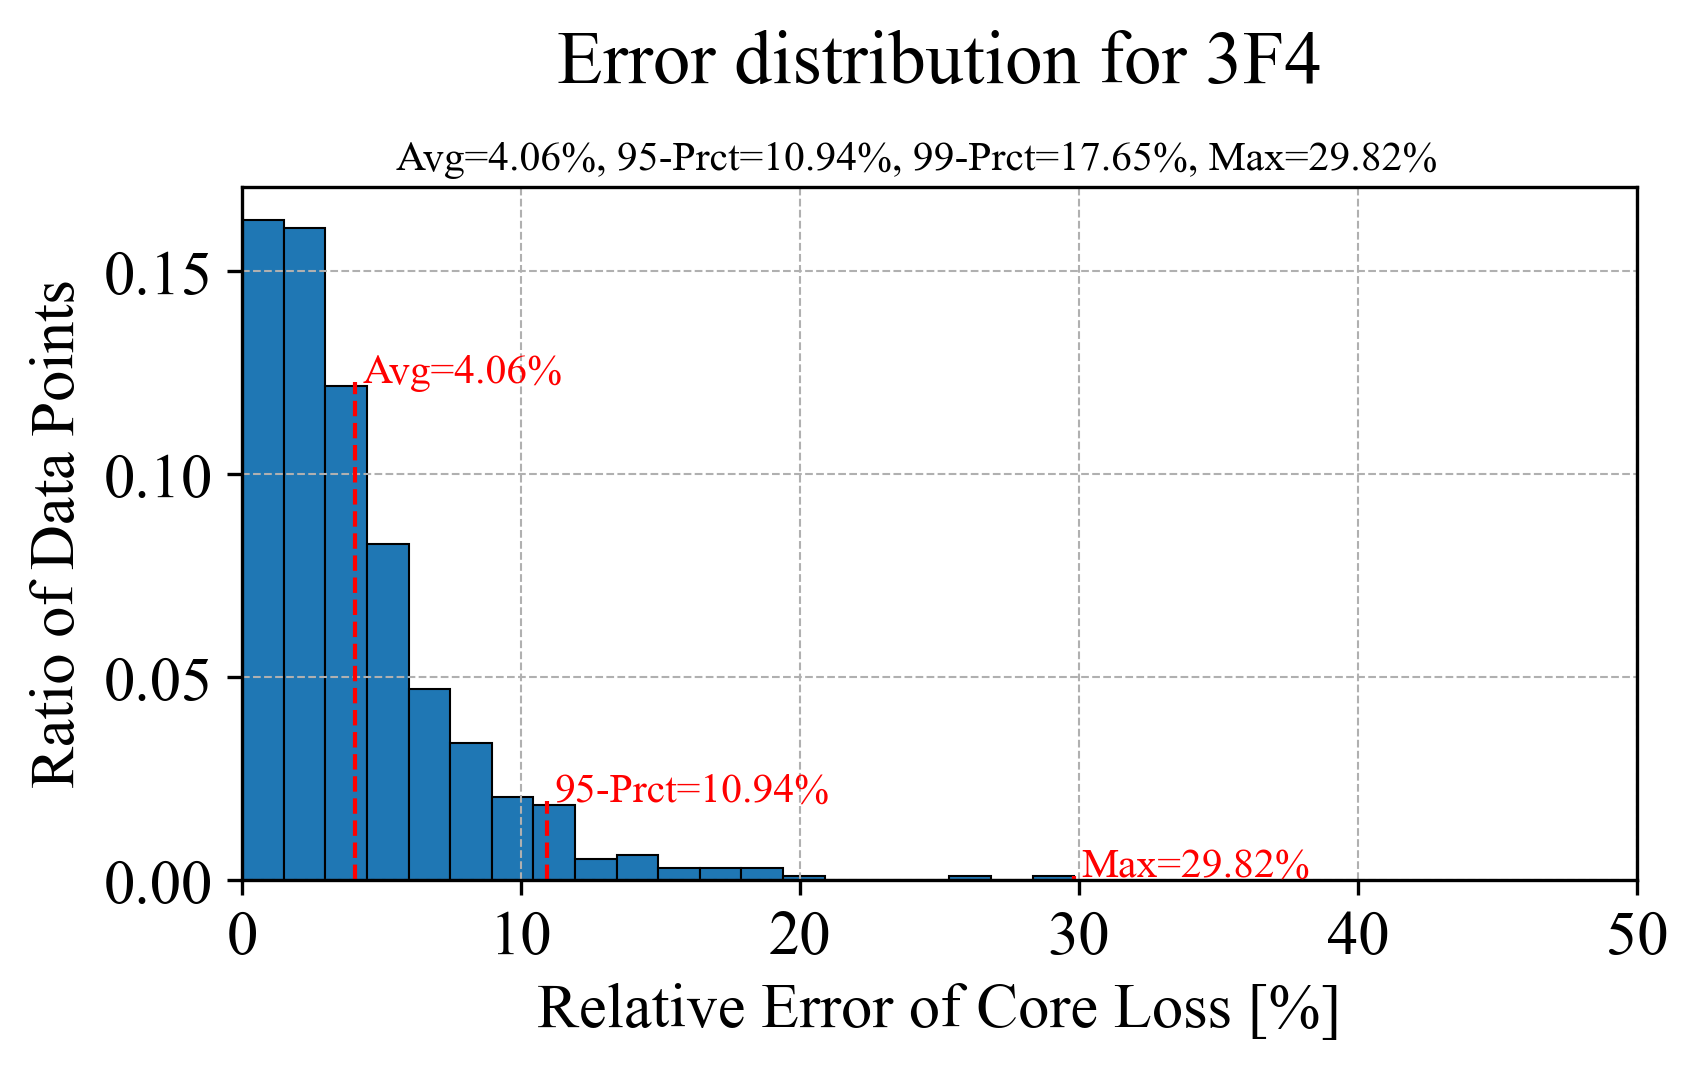

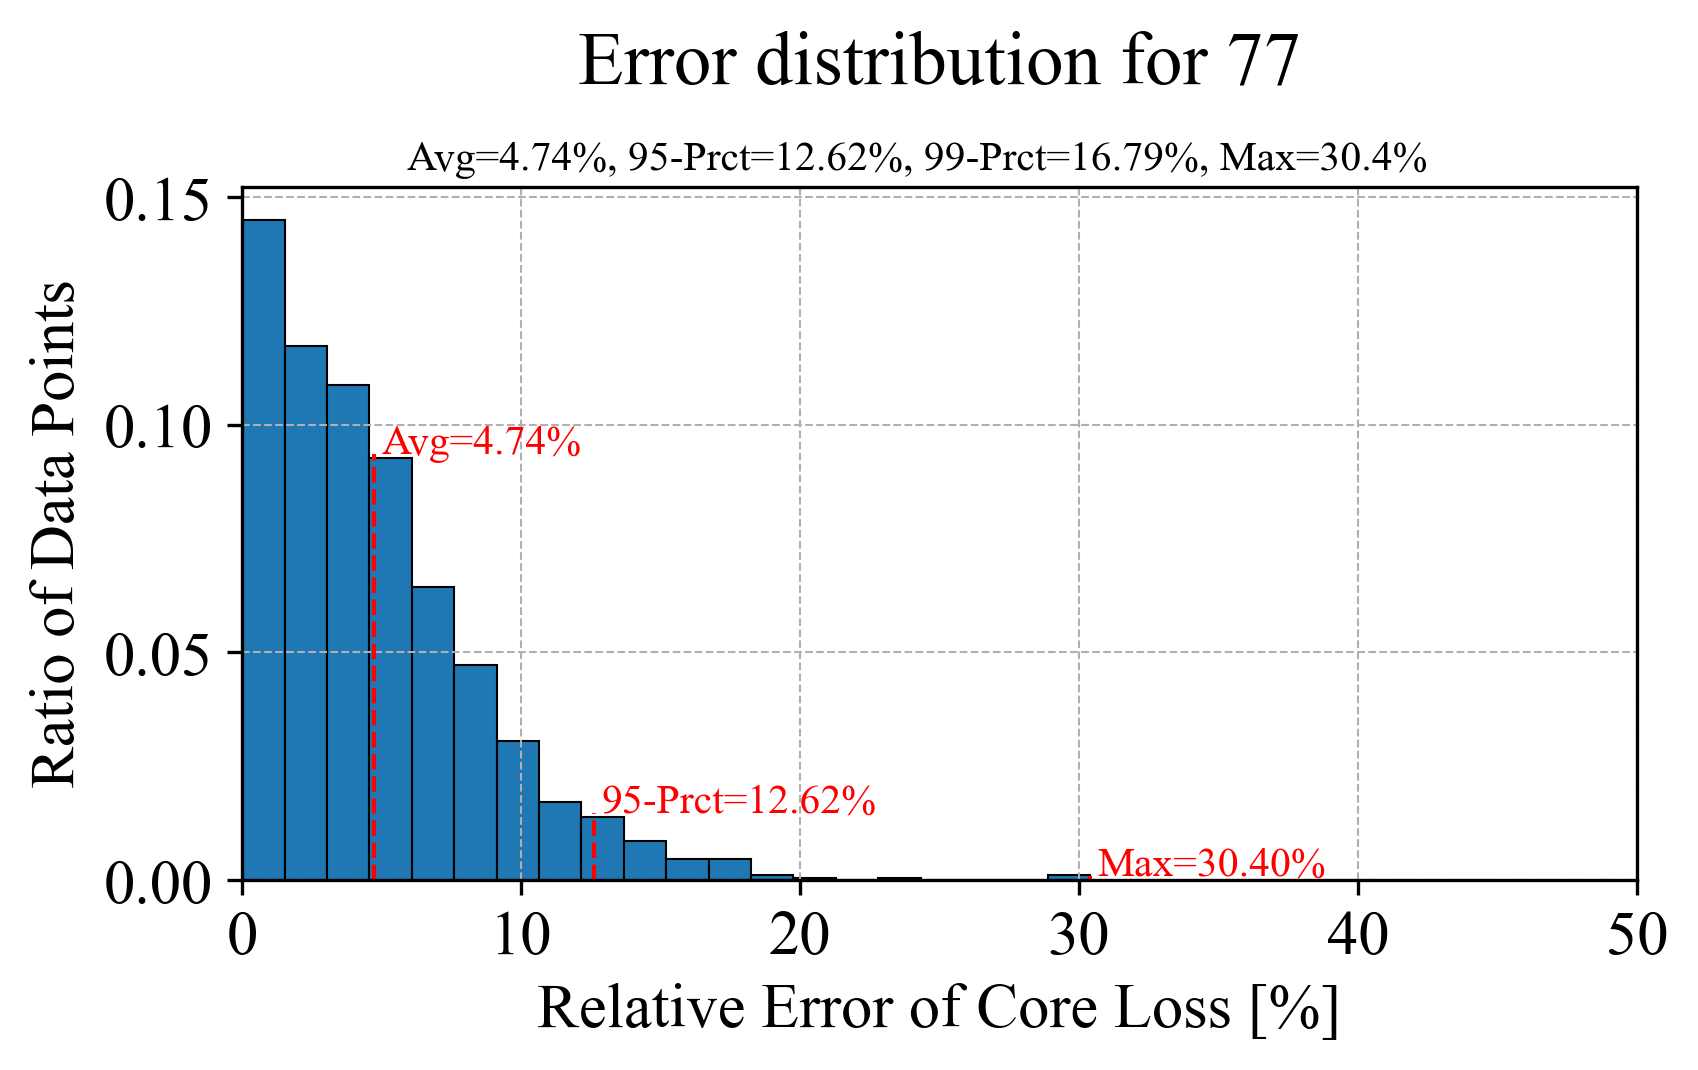

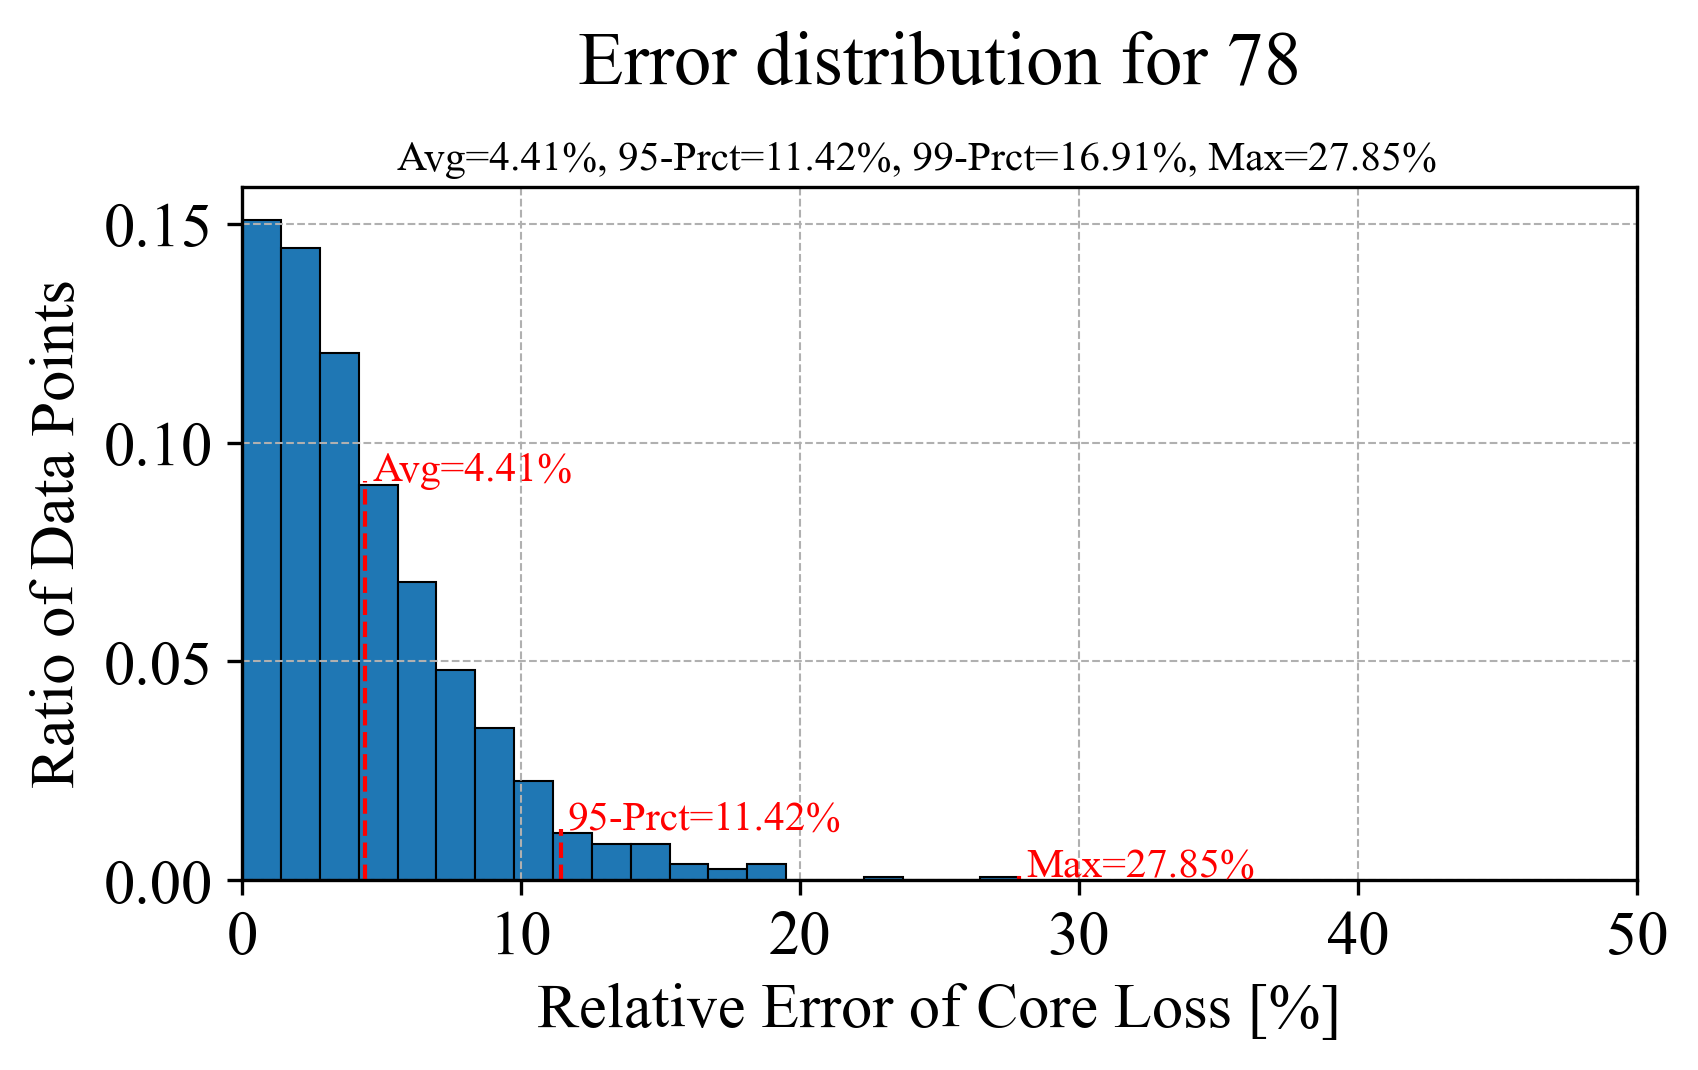

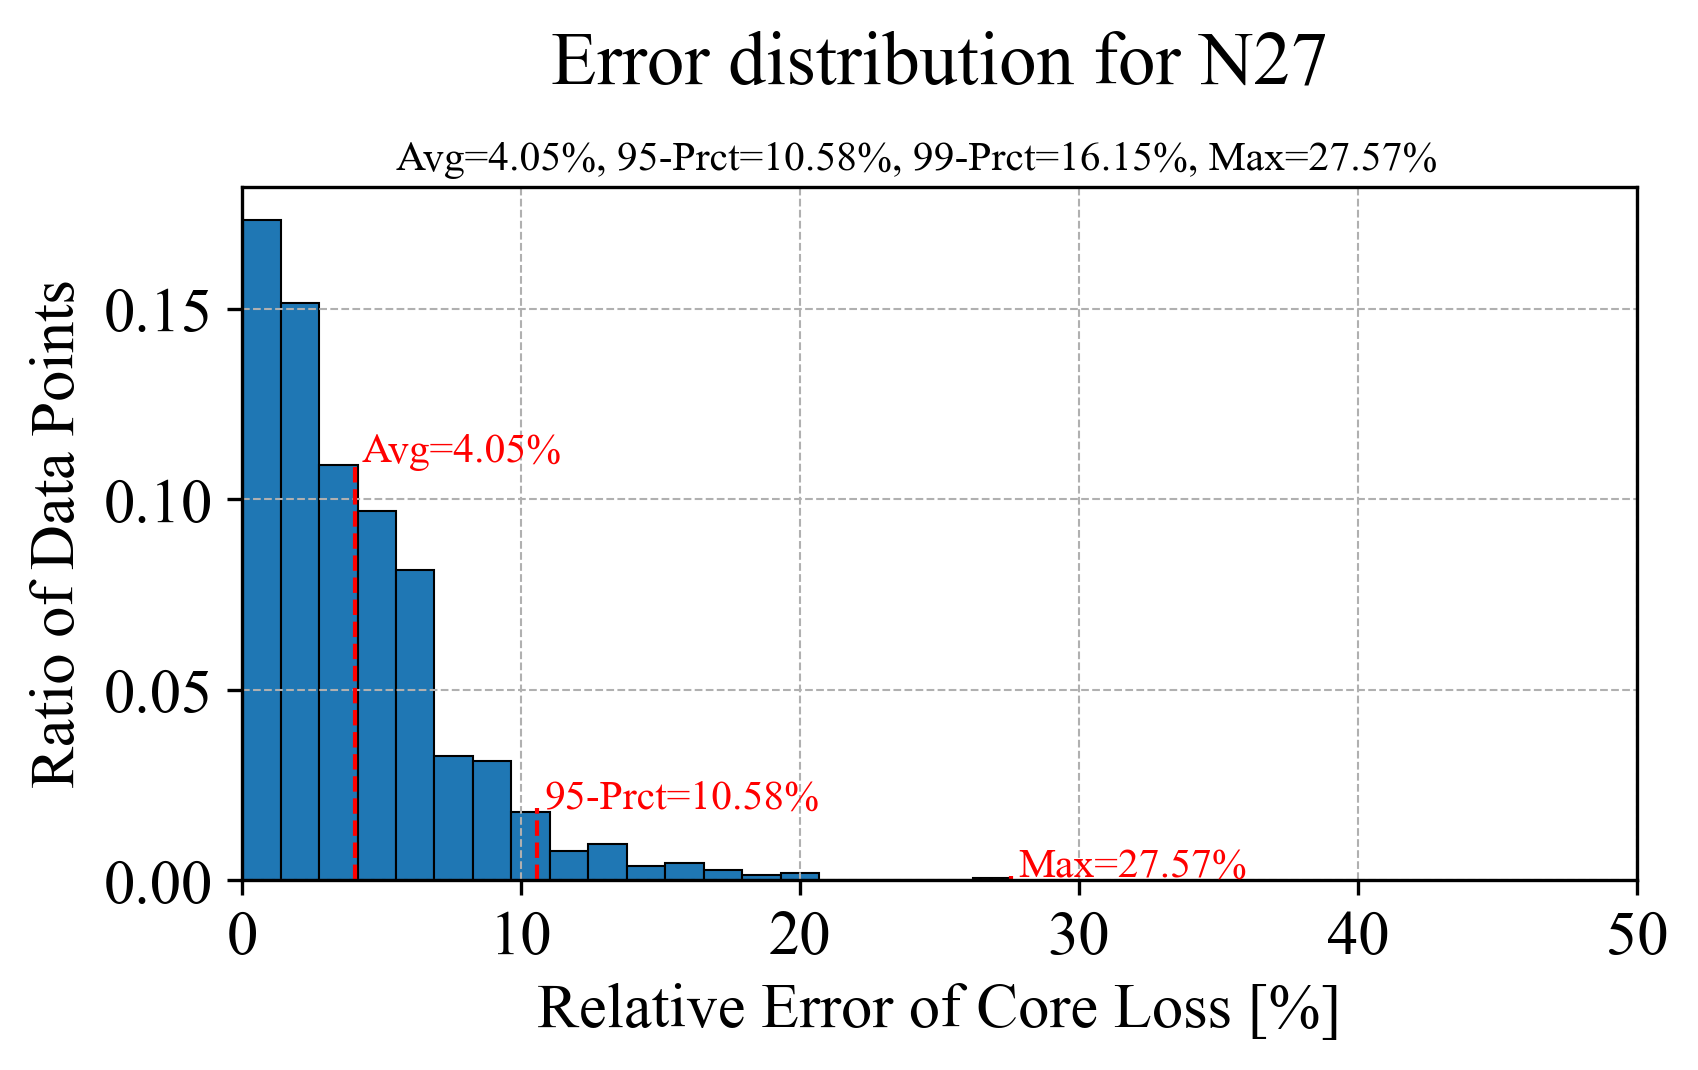

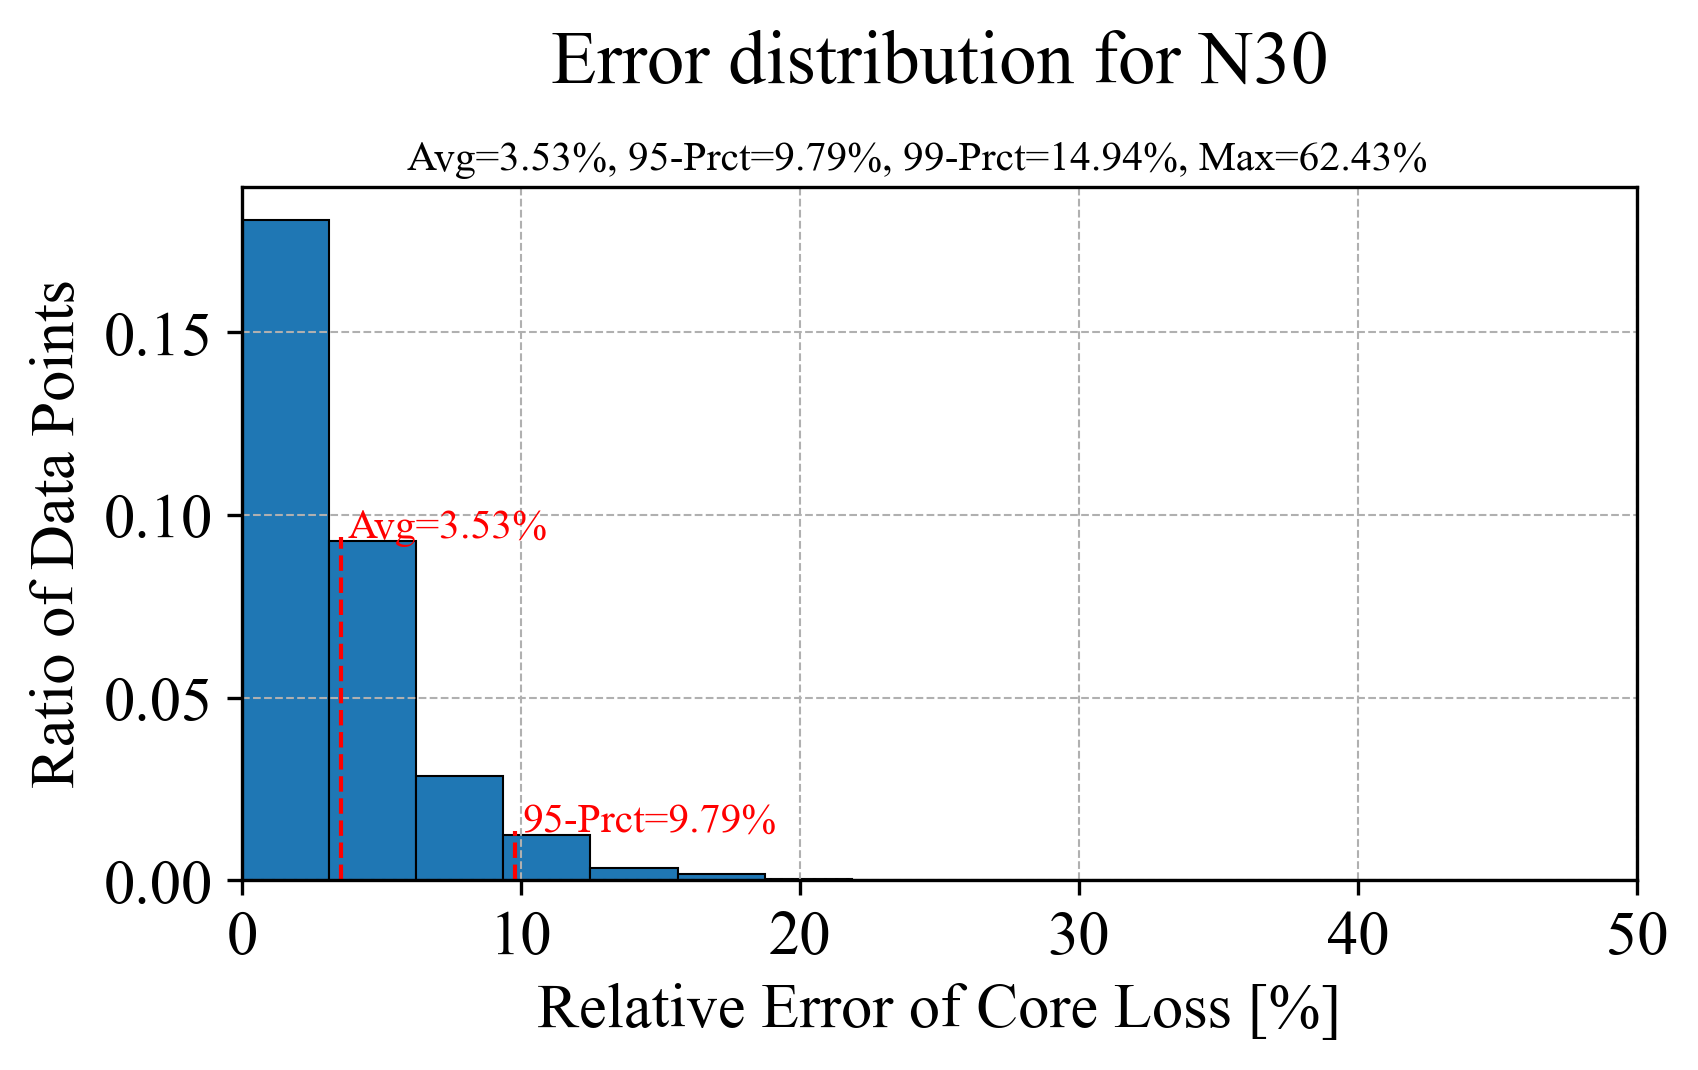

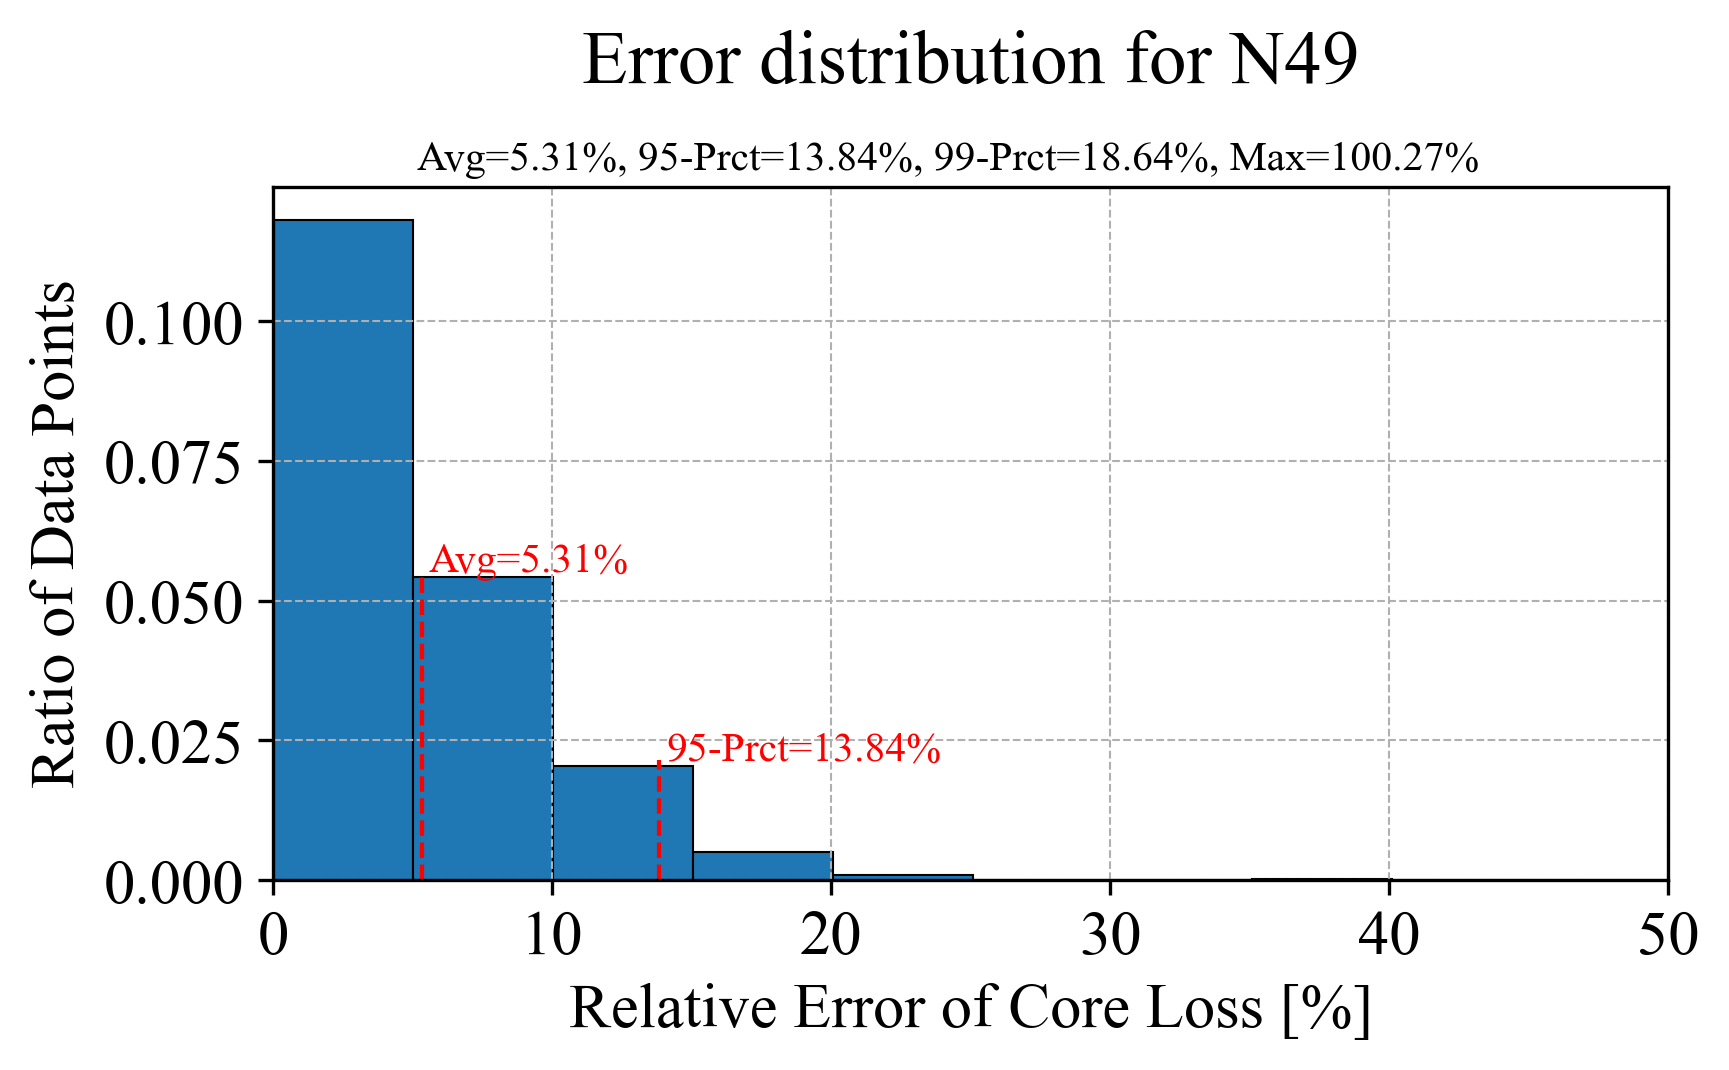

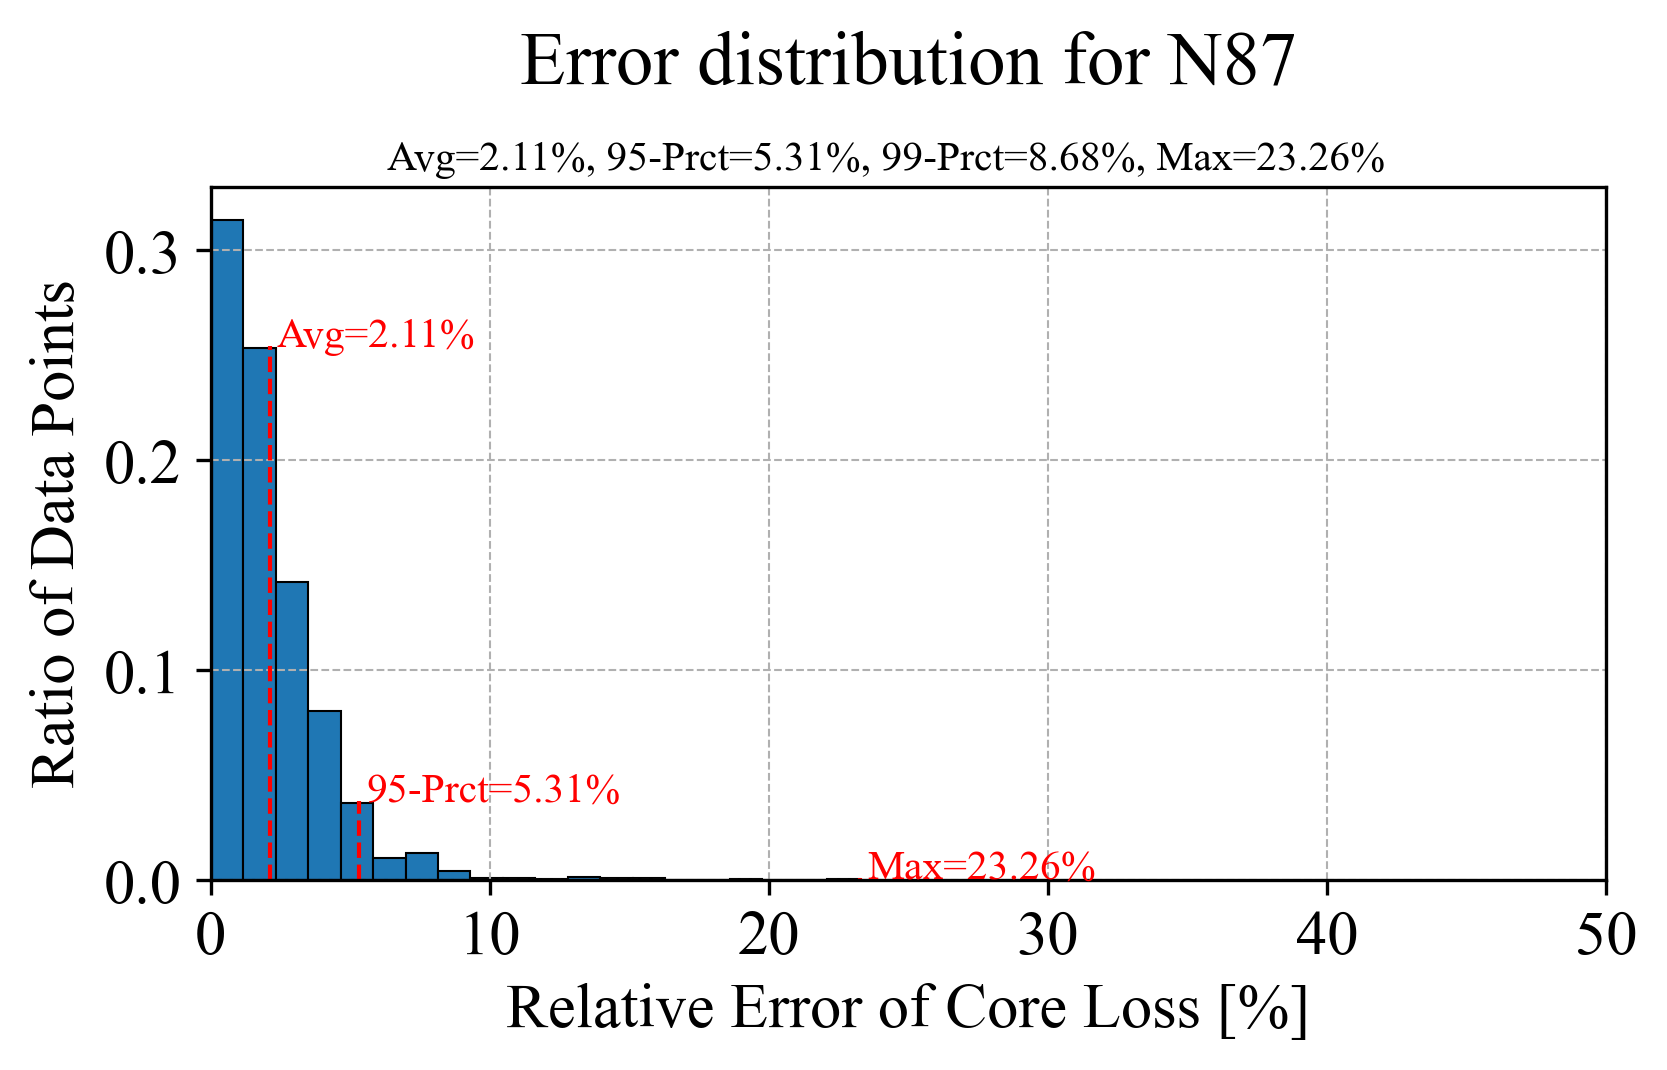

In [8]:
import Maglib

error_summary = []
data = []

for material in weights:
    magData = Maglib.MagLoader(os.path.join(training_data_dir, material, 'test.mat'))

    # Instantiate the model with appropriate dimensions
    model = NW_LSTM.get_global_model().to(device)
    model.load_state_dict(torch.load(os.path.join(weights_dir, f'{material}.ckpt'), map_location=device)) # Load trained material model from .ckpt file

    num_samples = min(magData.b.shape[0], max_samples)  # Limits number of samples from validation dataset being used

    x_data = np.zeros([num_samples, magData.b.shape[1], 3])
    x_data[:, :, 0] = magData.b[:num_samples]
    x_data[:, :, 1] = magData.freq[:num_samples]
    x_data[:, :, 2] = magData.temp[:num_samples]

    y_data = magData.loss[:num_samples]

    # Now we can pass a batch of sequences through the model
    inputs = torch.tensor(x_data, dtype=torch.float32)
    outputs = model(inputs)
    total_params = sum(p.numel() for p in model.parameters())

    print('Data size ', magData.b.shape[0])
    print('model parameters: ', total_params)

    # get model performance
    pred = outputs.detach().numpy() # Get loss prediction
    real = y_data # Actual losses

    import linear_std
    import MagNet

    std_loss = linear_std.linear_std()
    std_loss.load(os.path.join(training_data_dir, material, 'std_loss.stdd'))

    pred = std_loss.unstd(pred)
    real = std_loss.unstd(real)

    relv_error = abs(pred - real) / real # Relative absolute error
    mean_relv_error = np.mean(relv_error)
    errors = {
        'mean_error': mean_relv_error, 
        '95_percentile_error': np.percentile(relv_error, 95), 
        '99_percentile_error': np.percentile(relv_error, 99),
        'max_error': relv_error.max
    }
    error_summary.append(errors)

    record = {'material': material}
    record.update(errors)
    data.append(record)

    # Plot and save error histogram
    MagNet.Mag_plot(material, relv_error, os.path.join(validation_dir, f'{material}.pdf'))

dataframe = pd.DataFrame(data) # Create error dataframe of dictionary lists
dataframe.to_csv(os.path.join(validation_dir, 'model_errors.csv'), index=False)


In [6]:
# Check if CUDA is available and if so, set the device to GPU
device = torch.device("cpu")
print("Device using ", device)

class MyDataset(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

Device using  cpu


In [7]:
if(0):
    bad_example=[]
    good_example=[]
    for idx in range(error.shape[0]):
        if abs(error[idx])>0.2:
            bad_example.append(idx)
        elif abs(error[idx])<0.04:
            good_example.append(idx)


    std_temp= linear_std.linear_std()
    std_temp.load(data_dir+r"\std_temp.stdd")

    std_freq= linear_std.linear_std()
    std_freq.load(dataset_path+r"\std_freq.stdd")


    bad_freq=[]
    bad_temp=[]

    good_freq=[]
    good_temp=[]

    for idx in bad_example:
        bad_freq.append(std_freq.unstd(magData.freq[idx]))
        bad_temp.append(std_temp.unstd(magData.temp[idx]))

    for idx in good_example:
        good_freq.append(std_freq.unstd(magData.freq[idx]))
        good_temp.append(std_temp.unstd(magData.temp[idx]))


    # plot the distribution of good_freq vs bad_freq
    plt.figure()
    plt.title("error distribution in freq")
    plt.hist(np.array(good_freq),label="good")
    plt.hist(np.array(bad_freq),label="bad")
    plt.legend()
    plt.show()

    # plot the distribution of good_temp vs bad_temp
    plt.figure()
    plt.title("error distribution in temp")
    plt.hist(np.array(good_temp),label="good")
    plt.hist(np.array(bad_temp),label="bad")
    plt.legend()
    plt.show()

    # plot the distribution of error
    drawing=False

    if drawing:
        for idx in bad_example:
            plt.figure()
            # using title to show the temp and freq
            plt.title('temp: ' + str(std_temp.unstd(magData.temp[idx])) +
                    '\nfreq: ' + str(std_freq.unstd(magData.freq[idx])))

            plt.plot(magData.b[idx,:])
            plt.show()